# Settings

In [ ]:
!pip install -Uq fastai2

     |████████████████████████████████| 179 kB 4.7 MB/s 


In [ ]:
from google.colab import drive
from fastai.vision.all import *
from sklearn.metrics import classification_report
import pathlib

drive.mount('/content/gdrive')
path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15' # /train_augmentation'

Mounted at /content/gdrive


In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, final_losses=True, perc=.5, **kwargs):
    
    n_values = len(self.recorder.values)
    if n_values < 2:
        print('not enough values to plot a chart')
        return
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    metric_names = [m.replace("valid_", "") for m in self.metric_names[1:-1] if 'loss' not in m and 'train' not in m]
    if final_losses:
        sel_idxs = int(round(n_values * perc))
        if sel_idxs < 2:
            final_losses = False 
        else:
            names = names + ['train_final_loss', 'valid_final_loss']
            self.loss_idxs = L([i for i,n in enumerate(self.metric_names[1:-1]) if 'loss' in n])
            metrics = np.concatenate([metrics, metrics[:, self.loss_idxs]], -1) 

    n = int(1 + final_losses + len(self.metrics))
    if nrows is None and ncols is None:
        if n <= 3: 
            nrows = 1
        else:
            nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6 + ncols - 1, nrows * 4 + nrows - 1)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = axs.flatten()[:n]
    for i,name in enumerate(names):
        xs = np.arange(0, len(metrics))
        if name in ['train_loss', 'valid_loss']: 
            ax_idx = 0
            m = metrics[:,i]
            title = 'losses'
        elif name in ['train_final_loss', 'valid_final_loss']: 
            ax_idx = 1
            m = metrics[-sel_idxs:,i]
            xs = xs[-sel_idxs:]
            title = 'final losses'
        else: 
            ax_idx = metric_names.index(name.replace("valid_", "").replace("train_", "")) + 1 + final_losses
            m = metrics[:,i]
            title = name.replace("valid_", "").replace("train_", "")
        if 'train' in name:
            color = '#1f77b4'
            label = 'train'
        else:
            color = '#ff7f0e'
            label = 'valid'
            axs[ax_idx].grid(color='gainsboro', linewidth=.5)
        axs[ax_idx].plot(xs, m, color=color, label=label)
        axs[ax_idx].set_xlim(xs[0], xs[-1])
        axs[ax_idx].legend(loc='best')
        axs[ax_idx].set_title(title)
    plt.show()

In [ ]:
hotels = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(train_name='train_augmentation', valid_name='validation'),
                   get_y=parent_label,
                   item_tfms=Resize(384),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

# Data already Augmented

In [ ]:
dls = hotels.dataloaders(path, bs=128)

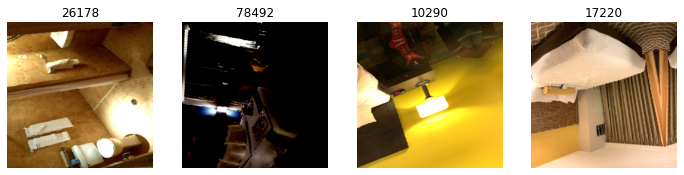

In [ ]:
dls.show_batch(nrows=1, ncols=4)

# Model

In [ ]:
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)

learn = vision_learner(dls, resnet50,
                metrics=[accuracy, error_rate, Dice, DiceMulti], 
                pretrained=True,
                loss_func=LabelSmoothingCrossEntropyFlat(),
                opt_func=partial(pytorch_adamw, 
                                 lr=0.0001,
                                 weight_decay=0.005, 
                                 eps=1e-08,
                                 betas=(0.9, 0.999)),
                cbs=[ShowGraphCallback(), EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=20)])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,5.285753,6.164108,0.044586,0.955414,326.334061,0.034672,24:07


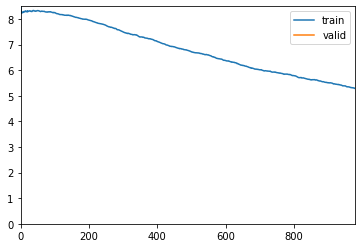

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,3.788883,5.371087,0.141865,0.858136,319.738309,0.121961,02:31
1,2.555789,4.886305,0.229299,0.770701,331.678184,0.202068,02:31
2,1.848078,4.839884,0.249566,0.750434,332.307149,0.224419,02:32


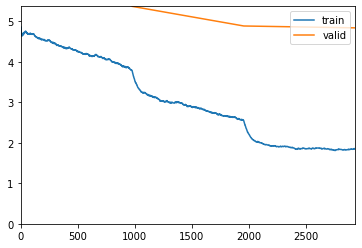

In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,4.003134,5.563309,0.115229,0.884771,314.443114,0.102299,02:31
1,2.908318,4.988311,0.216561,0.783440,336.751346,0.191664,02:31
2,2.015890,4.502820,0.292994,0.707006,336.259721,0.260423,02:31
3,1.588768,4.405909,0.312102,0.687898,338.870091,0.277098,02:32


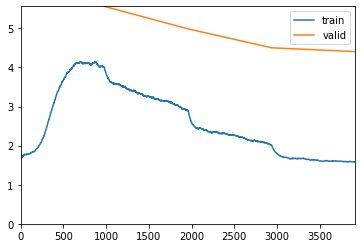

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4)
learn.freeze()

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.791284,4.631525,0.283729,0.716271,336.922973,0.254608,02:16


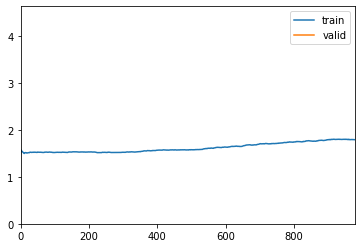

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.544603,4.373633,0.313839,0.686161,338.291207,0.281928,02:32
1,1.517586,4.325633,0.323683,0.676317,337.638172,0.293509,02:32
2,1.375461,4.258244,0.327736,0.672264,335.125565,0.296656,02:32
3,1.284530,4.156407,0.350318,0.649682,341.112877,0.309876,02:31
4,1.259004,4.161010,0.351477,0.648523,338.647771,0.309833,02:31


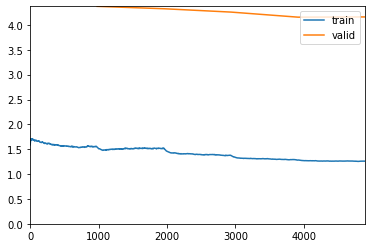

In [ ]:
learn.fine_tune(5)

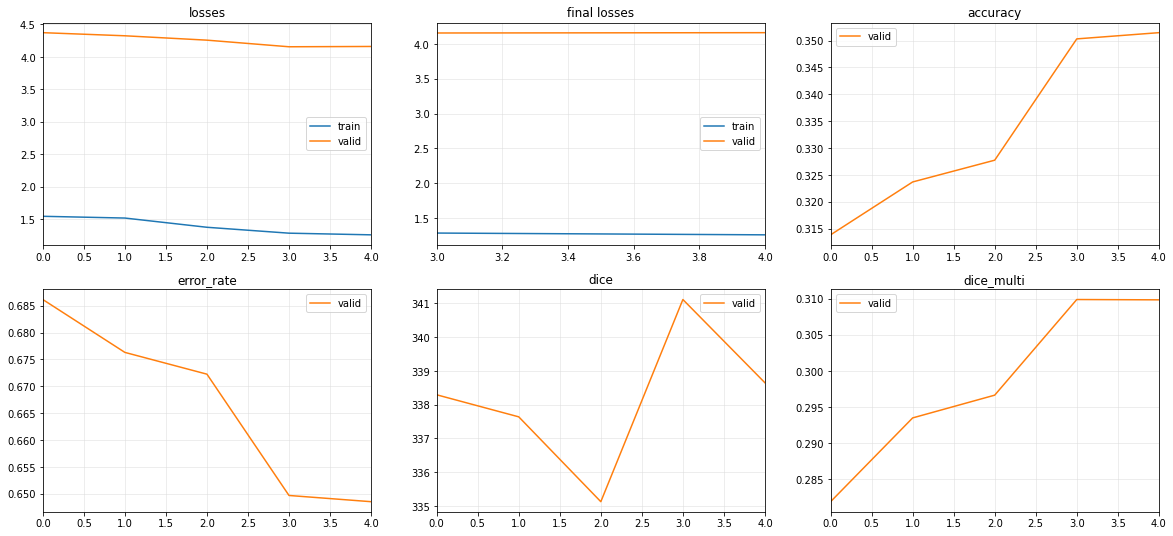

In [ ]:
learn.recorder.plot_metrics()

In [44]:
y_pred, y_true = learn.get_preds()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       0.50      0.20      0.29         5
           7       0.33      0.50      0.40         2
           8       0.33      0.50      0.40         4
           9       1.00      0.50      0.67         2
          10       1.00      0.33      0.50         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.50      0.57      0.53         7
          14       1.00      1.00      1.00         2
          15       0.00      0.00      0.00         3
          16       1.00      0.14      0.25         7
          17       0.00    

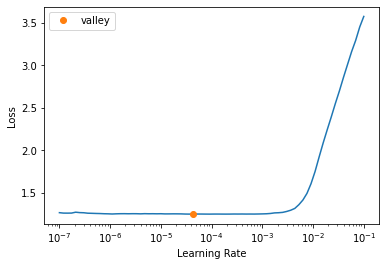

In [61]:
c = learn.lr_find()

In [62]:
print(c.valley)

4.365158383734524e-05


epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.207528,4.186098,0.353214,0.646786,340.490074,0.313578,02:32
1,1.203695,4.177082,0.353793,0.646207,341.319307,0.309490,02:33
2,1.190608,4.163346,0.353214,0.646786,340.658269,0.308884,02:33
3,1.184205,4.152359,0.359004,0.640996,344.042046,0.310794,02:32


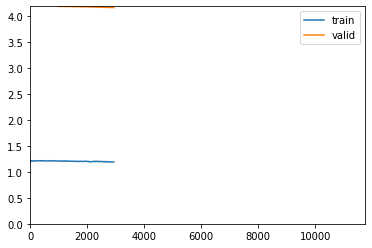

No improvement since epoch 0: early stopping


In [104]:
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(c.valley/10,c.valley))
learn.freeze()

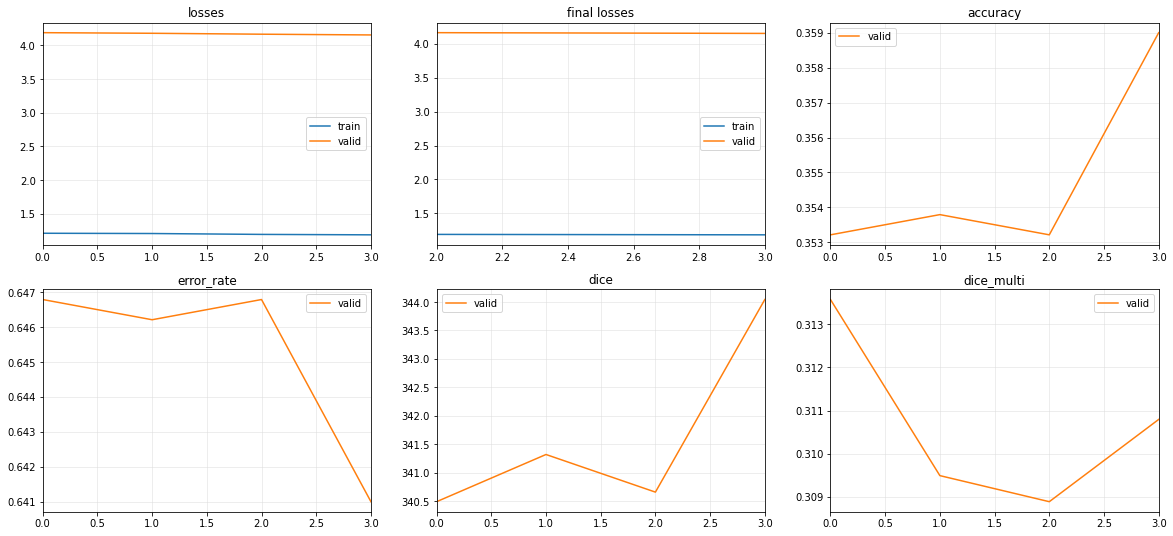

In [105]:
learn.recorder.plot_metrics()

In [71]:
y_pred, y_true = learn.get_preds()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.50      0.22         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       1.00      0.20      0.33         5
           7       0.25      0.50      0.33         2
           8       0.50      0.75      0.60         4
           9       1.00      0.50      0.67         2
          10       0.50      0.33      0.40         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.50      0.57      0.53         7
          14       1.00      1.00      1.00         2
          15       0.00      0.00      0.00         3
          16       1.00      0.14      0.25         7
          17       0.00    

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.395339,4.333021,0.314418,0.685582,336.171577,0.284729,02:16


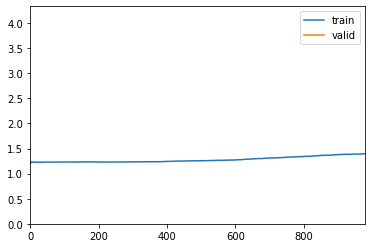

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.285260,4.216444,0.338738,0.661262,342.701428,0.301900,02:32
1,1.257454,4.154003,0.347423,0.652577,345.834240,0.308395,02:32
2,1.233755,4.174098,0.360741,0.639259,343.396479,0.316742,02:31
3,1.229880,4.169851,0.350898,0.649103,342.063838,0.308882,02:31
4,1.223354,4.168014,0.364215,0.635785,344.410144,0.323010,02:32
5,1.227507,4.207184,0.345686,0.654314,339.684964,0.305929,02:32


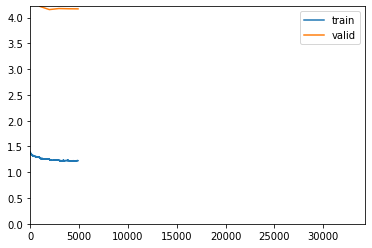

No improvement since epoch 2: early stopping


In [75]:
learn.fine_tune(35)

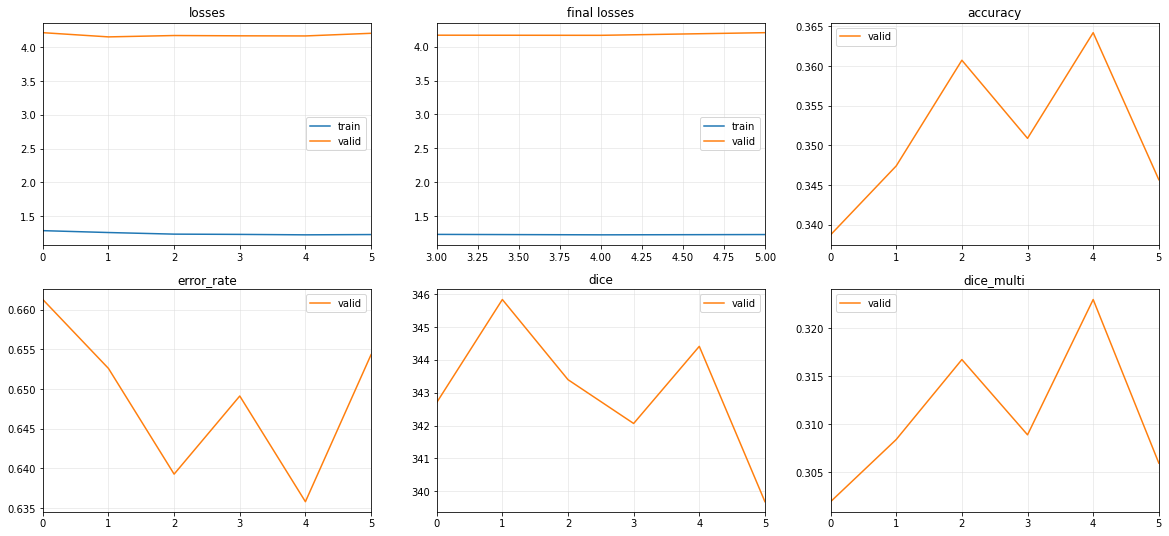

In [76]:
learn.recorder.plot_metrics()

In [77]:
y_pred, y_true = learn.get_preds()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.20      0.50      0.29         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       1.00      0.20      0.33         5
           7       0.00      0.00      0.00         2
           8       0.33      1.00      0.50         4
           9       0.00      0.00      0.00         2
          10       0.50      0.67      0.57         3
          11       0.00      0.00      0.00         2
          12       1.00      0.00      0.00         2
          13       0.57      0.57      0.57         7
          14       0.50      1.00      0.67         2
          15       1.00      0.00      0.00         3
          16       1.00      0.14      0.25         7
          17       1.00    

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,1.217565,4.209934,0.345686,0.654314,337.724716,0.303042,02:32
1,1.216218,4.209307,0.342791,0.657209,339.872878,0.303474,02:32
2,1.212610,4.198786,0.349739,0.650261,340.765155,0.305988,02:32
3,1.211805,4.192071,0.349160,0.650840,339.130044,0.307949,02:32


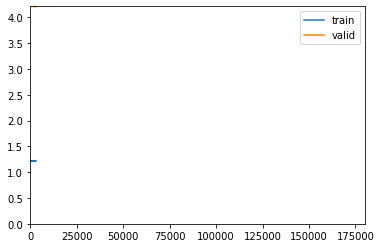

No improvement since epoch 0: early stopping


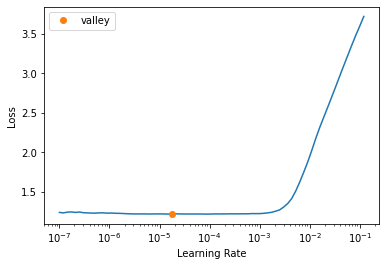

In [103]:
learn.unfreeze()
c = learn.lr_find()
learn.fit_one_cycle(184, lr_max=slice(c.valley/100, c.valley), cbs=[ShowGraphCallback()])
learn.freeze()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
y_pred, y_true = learn.get_preds()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, target_names=dls.vocab, zero_division=1))

# Saving

In [85]:
save_path = '/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Notebooks/Models/Resnet'

In [86]:
learn.save(f'{save_path}/model_resnet_final')
learn.export(f'{save_path}/model_resnet_final_pickle.pkl')

# Validate

In [79]:
learn.validate(ds_idx=0)

(#5) [1.1257872581481934,0.9999361634254456,6.384065636666492e-05,408.7474040479503,0.9999351401231736]

In [80]:
learn.validate(ds_idx=1)

(#5) [4.207184314727783,0.3456861674785614,0.654313862323761,339.68496449451237,0.3059288708409235]

In [82]:
root_path = "/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15"
p = pathlib.Path(root_path)
data = ImageDataLoaders.from_folder(path = p, train = "validation", validate="validation", item_tfms=Resize(384), bs = 128, batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [83]:
y_pred, y_true = learn.get_preds(dl = data.train)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       1.00      0.00      0.00         2
           6       1.00      0.20      0.33         5
           7       0.00      0.00      0.00         2
           8       0.27      1.00      0.42         4
           9       1.00      0.00      0.00         2
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       1.00      0.00      0.00         2
          13       0.57      0.57      0.57         7
          14       0.50      1.00      0.67         2
          15       0.00      0.00      0.00         3
          16       1.00      0.00      0.00         7
          17       1.00    